# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.0576827195017523
 0.15621747963523958
 0.7972379071395588
 0.5041717748804457
 0.9788369873307704
 0.32857760946046255
 0.19080995975564863
 0.6245537670607352
 0.41956722828674753
 0.36221451519254166
 ⋮
 0.6059005044736661
 0.47348561083883467
 0.5580729156974058
 0.8083787784688289
 0.4108986595838584
 0.031265099708610244
 0.999053567968582
 0.7012376427036304
 0.39110190974041836

In [2]:
sum(a)

5.001585375763136e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.001432 seconds (1 allocation: 16 bytes)


5.001585375763136e6

In [4]:
@time sum(a)

  0.001709 seconds (1 allocation: 16 bytes)


5.001585375763136e6

In [5]:
@time sum(a)

  0.001386 seconds (1 allocation: 16 bytes)


5.001585375763136e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [6]:
using Pkg
Pkg.add("BenchmarkTools")

   Resolving package versions...
    Updating `~/.julia/environments/v1.11/Project.toml`
  [6e4b80f9] + BenchmarkTools v1.6.0
    Updating `~/.julia/environments/v1.11/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.6.0
  [9abbd945] + Profile v1.11.0
Precompiling project...
    731.0 ms  ✓ BenchmarkTools
  1 dependency successfully precompiled in 2 seconds. 220 already precompiled.


In [7]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [15]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

# deleted -msse3
open(`gcc -fPIC -O3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [16]:
c_sum(a)

5.001585375763377e6

In [17]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [18]:
c_sum(a) - sum(a)  

2.4121254682540894e-7

In [19]:
≈  # alias for the `isapprox` function

isapprox (generic function with 13 methods)

In [20]:
?isapprox

Base.Meta.ParseError: ParseError:
# Error @ /Users/junchichen/Courses/Julia/Introduction-to-Julia/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X26sZmlsZQ==.jl:1:1
?isapprox
╙ ── not a unary operator

We can now benchmark the C code directly from Julia:

In [21]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 567 samples with 1 evaluation per sample.
 Range (min … max):  8.569 ms …  29.136 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     8.692 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.797 ms ± 957.874 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▂▂▇▅█▅▂▁                                                   
  ▄▆████████▆▄▃▄▄▅▄▄▅▃▃▂▁▂▃▃▁▂▂▂▂▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▂▂ ▃
  8.57 ms         Histogram: frequency by time        9.67 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [22]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 8.568583 msec


In [23]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 8.56858

In [24]:
using Plots
gr()

Plots.GRBackend()

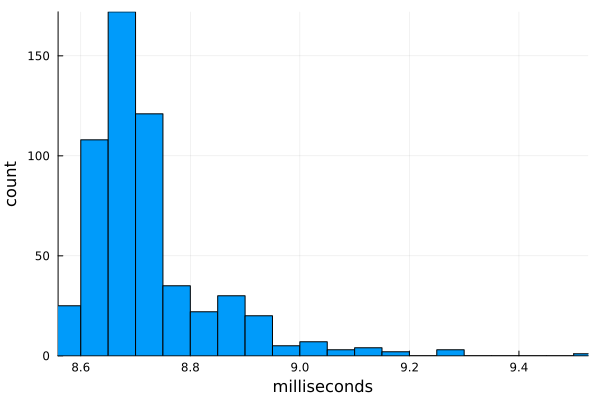

In [25]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [27]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
# deleted -msse3
open(`gcc -fPIC -O3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [28]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 3694 samples with 1 evaluation per sample.
 Range (min … max):  1.246 ms …   2.644 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.308 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.348 ms ± 100.184 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

      ▆█▄▁                                                     
  ▁▂▃▆████▆▅▅▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  1.25 ms         Histogram: frequency by time        1.73 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [29]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

1.245583

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [30]:
using Pkg; Pkg.add("PyCall")
using PyCall

   Resolving package versions...
   Installed PyCall ─ v1.96.4
    Updating `~/.julia/environments/v1.11/Project.toml`
  [438e738f] + PyCall v1.96.4
    Updating `~/.julia/environments/v1.11/Manifest.toml`
  [8f4d0f93] + Conda v1.10.2
  [438e738f] + PyCall v1.96.4
  [81def892] + VersionParsing v1.3.0
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/9816a3826b0ebf49ab4926e2b18842ad8b5c8f04/build.log`
Precompiling project...
    343.1 ms  ✓ VersionParsing
    696.5 ms  ✓ Conda
   5475.5 ms  ✓ PyCall
  3 dependencies successfully precompiled in 7 seconds. 221 already precompiled.


In [31]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [32]:
pysum(a)

5.001585375763377e6

In [33]:
pysum(a) ≈ sum(a)

true

In [34]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 12 samples with 1 evaluation per sample.
 Range (min … max):  416.256 ms … 479.693 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     416.950 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   430.477 ms ±  23.287 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                              
  █▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  416 ms           Histogram: frequency by time          480 ms <

 Memory estimate: 208 bytes, allocs estimate: 8.

In [35]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 8.56858
  "Python built-in" => 416.256
  "C -ffast-math"   => 1.24558

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [36]:
using Pkg; Pkg.add("Conda")
using Conda

   Resolving package versions...
    Updating `~/.julia/environments/v1.11/Project.toml`
  [8f4d0f93] + Conda v1.10.2
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [37]:
Conda.add("numpy")

┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda /Users/junchichen/.julia/packages/Conda/zReqD/src/Conda.jl:181


Channels:
 - conda-forge
Platform: osx-arm64
Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
    current version: 25.3.0
    latest version: 25.5.1

Please update conda by running

    $ conda update -n base -c conda-forge conda




In [38]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 2519 samples with 1 evaluation per sample.
 Range (min … max):  1.896 ms …   2.961 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.943 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.980 ms ± 122.896 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂█▅▃                                                         
  ██████▆▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  1.9 ms          Histogram: frequency by time        2.61 ms <

 Memory estimate: 208 bytes, allocs estimate: 8.

In [39]:
numpy_sum(a)

5.001585375763136e6

In [40]:
numpy_sum(a) ≈ sum(a)

true

In [41]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 8.56858
  "Python numpy"    => 1.89592
  "Python built-in" => 416.256
  "C -ffast-math"   => 1.24558

# 5. Python, hand-written 

In [42]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x322dd9080>

In [43]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 11 samples with 1 evaluation per sample.
 Range (min … max):  463.886 ms … 487.461 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     480.127 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   478.409 ms ±   7.565 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

                                            █                    
  ▇▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▇▇█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▇ ▁
  464 ms           Histogram: frequency by time          487 ms <

 Memory estimate: 208 bytes, allocs estimate: 8.

In [44]:
sum_py(a)

5.001585375763377e6

In [45]:
sum_py(a) ≈ sum(a)

true

In [46]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 8.56858
  "Python numpy"        => 1.89592
  "Python hand-written" => 463.886
  "Python built-in"     => 416.256
  "C -ffast-math"       => 1.24558

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [47]:
@which sum(a)

sum(a::AbstractArray; dims, kw...)
     @ Base reducedim.jl:982

In [48]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 3763 samples with 1 evaluation per sample.
 Range (min … max):  1.247 ms …  1.683 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.298 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.323 ms ± 63.846 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

       ▂▇█▇▄▁▁                                                
  ▂▄▄▅▇████████▆▅▄▄▄▄▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁ ▃
  1.25 ms        Histogram: frequency by time        1.54 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [49]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 8.56858
  "Python numpy"        => 1.89592
  "Python hand-written" => 463.886
  "Python built-in"     => 416.256
  "Julia built-in"      => 1.24704
  "C -ffast-math"       => 1.24558

# 7. Julia (hand-written) 

In [50]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [51]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 556 samples with 1 evaluation per sample.
 Range (min … max):  8.571 ms … 32.097 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     8.786 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.987 ms ±  1.422 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▆██▆▂▁                                                    
  ▆█████████▆▆▄▄▄▄▃▃▅▃▃▂▄▃▄▃▃▃▂▂▁▁▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▂ ▃
  8.57 ms        Histogram: frequency by time        10.6 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [52]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 8.56858
  "Python numpy"        => 1.89592
  "Julia hand-written"  => 8.57062
  "Python hand-written" => 463.886
  "Python built-in"     => 416.256
  "Julia built-in"      => 1.24704
  "C -ffast-math"       => 1.24558

# 8. Julia (hand-written w. simd) 

In [53]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [54]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 3680 samples with 1 evaluation per sample.
 Range (min … max):  1.246 ms …   7.766 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.327 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.352 ms ± 164.682 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▁   ▁▁▂▁▄▇██▇▃                                              
  ▆█▅▇▅███████████▇▆▆▆▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂ ▄
  1.25 ms         Histogram: frequency by time        1.64 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [55]:
mysum_simd(a)

5.001585375763154e6

In [56]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 1.24625
  "C"                       => 8.56858
  "Python numpy"            => 1.89592
  "Julia hand-written"      => 8.57062
  "Python hand-written"     => 463.886
  "Python built-in"         => 416.256
  "Julia built-in"          => 1.24704
  "C -ffast-math"           => 1.24558

# Summary

In [57]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

C -ffast-math...............1.2
Julia hand-written simd.....1.2
Julia built-in..............1.2
Python numpy................1.9
C...........................8.6
Julia hand-written..........8.6
Python built-in...........416.3
Python hand-written.......463.9
